<a href="https://colab.research.google.com/github/easajtar20/Classification-of-Long-Distance-Longboarding/blob/main/Week3Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Run

Folder ./graphs already exists
pumping_.csv
shape of the features array is (25, 5)
pumping_ - goofy, phone in left hand.csv
shape of the features array is (14, 5)
pumping_ - goofy, phone in right hand.csv
shape of the features array is (14, 5)
pumping_, goofy, chest pocket.csv
shape of the features array is (15, 5)
pumping_ - standard, low deck, right hip pocket.csv
shape of the features array is (42, 5)
pumping_ - goofy, low deck, right hip pocket.csv
shape of the features array is (32, 5)
pushing_.csv
shape of the features array is (1, 5)
pushing_2.csv
shape of the features array is (14, 5)
pushing_ - standard.csv
shape of the features array is (14, 5)
pushing_ - goofy.csv
shape of the features array is (14, 5)
pushing_ - standard, low deck, right hip pocket.csv
shape of the features array is (32, 5)
pushing_ - goofy, low deck, right hip pocket.csv
shape of the features array is (38, 5)
coasting_.csv
shape of the features array is (14, 5)
carving_.csv
shape of the features array is (

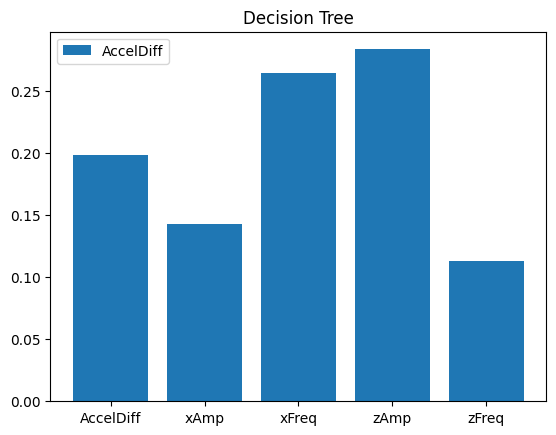

trained Decision Tree in 0.00 s


,classifier,train_score,test_score,train_time
1,Decision Tree,1.000000,1.000000,0.002494
0,Logistic Regression,0.696113,0.403509,0.013298


Logistic Regression  F1 0.67 with a standard deviation of 0.11
Logistic Regression  Accuracy 0.67 with a standard deviation of 0.11
Decision Tree  F1 0.69 with a standard deviation of 0.12
Decision Tree  Accuracy 0.70 with a standard deviation of 0.11


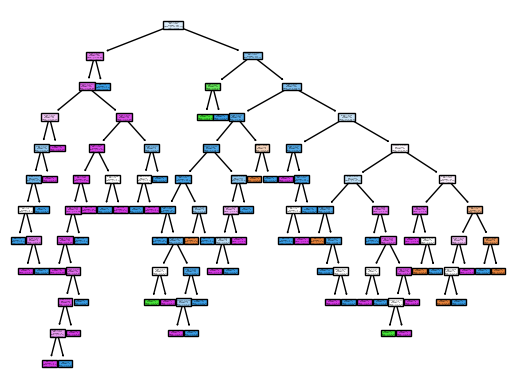

In [83]:
main()

# Main

In [82]:
import os
from sklearn import svm
from sklearn.model_selection import cross_val_score

def main():

	p = './graphs'
	if not os.path.exists(p):
		os.mkdir(p)
		print("Folder %s created!" % p)
	else:
		print("Folder %s already exists" % p)
  
	hParams = {
		"datasetProportion": 1.0,
		"numEpochs": 50,
		"denseLayers": [14, 20, 10, 4, 1],
		"valProportion": 0.1,
		"experimentName": "ML_results",
		"waveletName": 	"rbio3.1"
	}

	x_train, y_train = getFeaturesTrainData()

	x_test, y_test = x_train[int(0.8 * x_train.shape[0]):], y_train[int(0.8 * y_train.shape[0]):]


	print(x_train.shape, y_train.shape)
	#print("Training Data", x_train, y_train)
	#print("Testing Data",x_test, y_test)


	dataSubsets = (x_train, y_train, x_test, y_test)
	trainResults = batch_classify(dataSubsets)

	display_dict_models(trainResults)

  # Cross Validation
	clf = svm.SVC(kernel='linear', C=1, random_state=42)
	for classifier_name, classifier in list(dict_classifiers.items()):
		f1scores = cross_val_score(classifier, x_train, y_train, cv=10, scoring = 'f1_micro')
		print(classifier_name, " F1 %0.2f with a standard deviation of %0.2f" % (f1scores.mean(), f1scores.std()))
		scores = cross_val_score(classifier, x_train, y_train, cv=10, scoring = 'accuracy')
		print(classifier_name, " Accuracy %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

#Get Data

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path = "/content/drive/MyDrive/Longboarding/Longboard Project/Accelerometer Data/"

def getFeaturesTrainData():
	fileNames = ["pumping_.csv",  
							"pumping_ - goofy, phone in left hand.csv",
							"pumping_ - goofy, phone in right hand.csv",
							"pumping_, goofy, chest pocket.csv",
              "pumping_ - standard, low deck, right hip pocket.csv",
              "pumping_ - goofy, low deck, right hip pocket.csv",
              "pushing_.csv", 
							"pushing_2.csv", 
							"pushing_ - standard.csv",
							"pushing_ - goofy.csv",
              "pushing_ - standard, low deck, right hip pocket.csv",
              "pushing_ - goofy, low deck, right hip pocket.csv",
							"coasting_.csv", 
							"carving_.csv",
						]
							
	num_features = 5

	x_train = np.array([[0] * num_features])
	y_train = [""]

  # for each file listed above
	for fileName in fileNames:
		print(fileName)
	
		columns = ["az", "ay", "ax", "time", "Azimuth", "Pitch", "Roll"]
		df = pd.read_csv(path+fileName, usecols=columns)

    # specify a range of rows to collect based on time
		if fileName == "pumping_.csv":
			# data after 10 seconds and before final 3 seconds
			df = df.loc[(df["time"] > 10) & (df["time"] < df.iloc[-1]["time"] - 3)]
		else:
			# data after 3 seconds and before final 3 seconds
			df = df.loc[(df["time"] > 3) & (df["time"] < df.iloc[-1]["time"] - 3)]

	  # Verlet integration		
		df = rotatePhone(df)
		df = getDisplacementData(df)
		features = getFeaturesByWindow(df)

		x_train = np.concatenate((x_train, features))
	
		y_train += [fileName.split("_")[0]] * features.shape[0]

	for i in range(len(x_train)):
		if (x_train[i] == [0]*num_features).any() or np.isnan(np.sum(x_train)):
			x_train = np.delete(x_train, i, 0)
			y_train = np.delete(y_train, i, 0)

		if i >= len(x_train) - 1:
			break
	
	y_train = np.array(y_train)
	return x_train, y_train

Mounted at /content/drive


#Manipulate Data

In [72]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq

from sklearn import preprocessing

# what if the dimensions are divided into 2 parts, one part contains 2 dimensions and the other 1, the part where the derivative is lowest is deemed to be the dimension of movement, and the other 2 are the dimensions of wave oscillation
# different data normalization methods were tested, below is the z-score normalization method (you can look it up, but it basically makes data easier to process)
def normalize_data(df):

	# Get mean & standard deviation of raw acceleration data
	meanx, stdx = df.ax.mean(), df.ax.std()
	meany, stdy = df.ay.mean(), df.ay.std()
	meanz, stdz = df.az.mean(), df.az.std()

	# Get max & min of raw acceleration data
	maxx, minx = df.ax.max(), df.ax.min()
	maxy, miny = df.ay.max(), df.ay.min()	
	maxz, minz = df.az.max(), df.az.min()

	# Do the calculating
	for i in range(len(df)):
		df.ax[i] = (df.ax[i] - minx) / (maxx - minx)
		df.ay[i] = (df.ay[i] - miny) / (maxy - miny)
		df.az[i] = (df.az[i] - minz) / (maxz - minz)
	
	return df


# input: arrays of displacement vectors in 3 dimensions after 2 seconds
# get angle of the vector from each dimension, trigonometry
def normalize_vector(xx, xy, xz):
	lx, ly, lz = xx[-1] - xx[0], xy[-1] - xy[0], xz[-1] - xz[0]
  
	hypo = (lx ** 2 + ly ** 2 + lz ** 2) ** 0.5 
	side1 = (lx ** 2 + ly ** 2) ** 0.5
	side2 = ly
	
	newPitch = ((np.arctan(side1 / hypo) * 180) / np.pi)
	newAzimuth = ((np.arccos(side2 / hypo) * 180) / np.pi)
	
	return newPitch, newAzimuth

# Method to Verlet integrate the raw acceleration data
def getDisplacementData(df):
	transformed_acceleration = []

	delta_v, xt, delta_t, prev_pos, pos = 0, [[0, 0, 0]], 0, [0] * 3, [0] * 3

	for i in range(len(df) - 1):
		delta_t = df.iloc[i + 1]['time'] - df.iloc[i]['time']
		delta_v = [df.iloc[i]['rotated_ax'], df.iloc[i]['rotated_ay'], df.iloc[i]['rotated_az']]
		pos = [x + y for (x, y) in zip([(2 * y) - z for (y, z) in zip(pos, prev_pos)], [delta_v[0] * (delta_t ** 2), delta_v[1] * (delta_t ** 2), delta_v[2] * (delta_t ** 2)])]
		xt.append(pos)
		prev_pos = pos

	df['rotated_xx'] = [x[0] for x in xt] 
	df['rotated_xy'] = [x[1] for x in xt]
	df['rotated_xz'] = [x[2] for x in xt]

	return df

# rotate around x-axis
def rotateX(rad):
	return ([1, 0, 0],
	 				[0, np.cos(rad), np.sin(rad)],
	  			[0, -np.sin(rad), np.cos(rad)])

# rotate around y-axis
def rotateY(rad):
	return ([np.cos(rad), 0, -np.sin(rad)],
	 				[0, 1, 0],
	  			[np.sin(rad), 0, np.cos(rad)])

# rotate around z-axis
def rotateZ(rad):
	return ([np.cos(rad), np.sin(rad), 0],
	 				[-np.sin(rad), np.cos(rad), 0],
	  			[0, 0, 1])

# rotate around all three axis
def rotation3D(matrix, x, y, z):
	alpha, beta, theta = np.deg2rad(x), np.deg2rad(y), np.deg2rad(z)
 
	rotation_matrix = np.matmul(np.matmul(rotateZ(theta), rotateY(beta)), rotateX(alpha))
	return np.matmul(rotation_matrix, matrix)
 
# rotate the data into a universal coordinate system by reversing the phone's rotation at the time of data collection
def rotatePhone(df):
	rotated_pos = []
	for index in range(len(df)):
		azimuth, pitch, roll = df['Azimuth'].iat[index], df['Pitch'].iat[index], df['Roll'].iat[index]
		pos_matrix = (df['ax'].iat[index], df['ay'].iat[index], df['az'].iat[index])
		rotated_pos.append(rotation3D(pos_matrix, -pitch, -roll, -azimuth))

	df['rotated_ax'] = [x[0] for x in rotated_pos]
	df['rotated_ay'] = [x[1] for x in rotated_pos]
	df['rotated_az'] = [x[2] for x in rotated_pos]

	return df

def getFeaturesByWindow(dataset):
	featuresPerWindow = []
	times = getTimes(dataset['time'])
	j = 0
	currentTime = times[j]
	# Create a dictionary of all the different data within 1 time window (period window)
	dict = {"time": [], "WindowStart": [],"xx": [], "xy": [], "xz": [], "az": [], "ax": [], "ay": [], "Azimuth": [], "Pitch": [], "Roll": []}

	for i in range(len(dataset)):

		# Get data from csv
		time = dataset.iloc[i]['time']
		xx = dataset.iloc[i]['rotated_xx']
		xy = dataset.iloc[i]['rotated_xy']
		xz = dataset.iloc[i]['rotated_xz']
		az = dataset.iloc[i]['rotated_az']
		ax = dataset.iloc[i]['rotated_ax']
		ay = dataset.iloc[i]['rotated_ay']
		Azimuth = dataset.iloc[i]['Azimuth']
		Pitch = dataset.iloc[i]['Pitch']
		Roll = dataset.iloc[i]['Roll']

    # Insert to dict
		dict['time'].append(time)
		dict['WindowStart'].append(currentTime)
		dict['xx'].append(xx)
		dict['xy'].append(xy)
		dict['xz'].append(xz)
		dict['ax'].append(ax)
		dict['ay'].append(ay)
		dict['az'].append(az)
		dict['Azimuth'].append(Azimuth)
		dict['Pitch'].append(Pitch)
		dict['Roll'].append(Roll)
	

    # when this is the last window
		if (i + 1 >= len(dataset) or j == len(times) - 1):
      # Process the features of the final window
			if len(dict['xx']) > 125:
				currentWindowFeatures = getFeatures(dict)
				if ~np.isnan(currentWindowFeatures).any():
					featuresPerWindow.append(currentWindowFeatures)
			break
    

    # when the next points are in a new window
		if (i + 1 != len(dataset)) and (dataset.iloc[i + 1]['time'] >= times[j + 1]):
      # Process the features of the current window
			if len(dict['xx']) > 125:
				currentWindowFeatures = getFeatures(dict)
				if ~np.isnan(currentWindowFeatures).any():
					featuresPerWindow.append(currentWindowFeatures)
			dict = {"time": [], "WindowStart": [], "xx": [], "xy": [], "xz": [], "az": [], "ax": [], "ay": [], "Azimuth": [], "Pitch": [], "Roll": []}
			j += 1
			currentTime = times[j]
   
	# normalize all of the features we processed
	normalizedFPW = preprocessing.normalize(np.array(featuresPerWindow))
	print("shape of the features array is", normalizedFPW.shape)

  # return an array where each element contains information about a single window
	return normalizedFPW

def getFeatures(dict):
	# rotate the position data so that the y-axis is in line with the direction of motion
	newRoll, newAzimuth = normalize_vector(dict['xx'], dict['xy'], dict['xz'])
	for i in range(len(dict['xx'])):
		pos_matrix = (dict['xx'][i], dict['xy'][i], dict['xz'][i])
		last = rotation3D(pos_matrix, -newRoll, 0, -newAzimuth)
		dict['xx'][i] = last[0]
		dict['xy'][i] = last[1]
		dict['xz'][i] = last[2]

		acc_matrix = (dict['ax'][i], dict['ay'][i], dict['az'][i])
		last = rotation3D(acc_matrix, -newRoll, 0, -newAzimuth)
		dict['ax'][i] = last[0]
		dict['ay'][i] = last[1]
		dict['az'][i] = last[2]

	features = []

	# y dimension -> acceleration, x, z dimensions -> position displacements
	a = np.array(dict["ay"])
	x1 = np.array(dict["xx"])
	x2 = np.array(dict["xz"])
	x3 = np.array(dict["xy"])
	'''
	fig = plt.figure()
	ax = fig.add_subplot(111, projection = '3d')
	ax.set_xlabel('x axis')
	ax.set_ylabel('y axis')
	ax.set_zlabel('z axis')
	ax.set_xlim([x1.min(), x1.min() + 0.025])
	ax.set_zlim([x2.min(), x2.min() + 0.025])
	ax.set_ylim([x3.min(), x3.min() + 0.025])
	plot = ax.scatter(x1, x3, x2, color = 'green')
	plt.show()
 
	# ground level view
	fig = plt.figure()
	ax = fig.add_subplot(111, projection = '3d')
	ax.view_init(elev=0, azim = 0)
	ax.set_xlabel('x axis')
	ax.set_ylabel('y axis')
	ax.set_zlabel('z axis')
	ax.set_xlim([x1.min(), x1.min() + 0.025])
	ax.set_zlim([x2.min(), x2.min() + 0.025])
	ax.set_ylim([x3.min(), x3.min() + 0.025])

	plot = ax.scatter(x1, x3, x2, color = 'green')
	plt.show()
	'''
	# Basically get the fourier transform plot of the position displacement data
	yf1 = rfft(np.array([x - x1.mean() for x in x1]))
	yf2 = rfft(np.array([x - x2.mean() for x in x2]))

	N = len(x1)
 
	# N = # of points 2 = # of secs per window
	samplingRate = N / 2

	freqx1 = rfftfreq(N, 1 / samplingRate)
	freqx2 = rfftfreq(N, 1 / samplingRate)
 
	peakx = np.max(yf1)
	peakz = np.max(yf2)
 
	maxfreqx = freqx1[np.argmax(np.abs(yf1))]
	maxfreqz = freqx2[np.argmax(np.abs(yf2))]

	'''
	plt.plot(freqx1[:30], np.abs(yf1[:30]))
	plt.title('New Plot')
	plt.xlabel('Frequency[Hz]')
	plt.ylabel('Amplitude')
	plt.show()
 
	plt.plot(freqx2[:30], np.abs(yf2[:30]))
	plt.title('New Plot')
	plt.xlabel('Frequency[Hz]')
	plt.ylabel('Amplitude')
	plt.show()
	print("peakx = ", peakx, "\nfreqx = ", maxfreqx, "\npeakz = ", peakz, "\nfreqz = ", maxfreqz)
	'''

	# This is the difference between the maximum and minimum accelerations in the y dimension
	features.append(a.max()-a.min())

  # x
	features.append((x1.max() - x1.min()) / 2)
	features.append(maxfreqx)
 
  # z
	features.append((x2.max() - x2.min()) / 2)
	features.append(maxfreqz)
	
	return np.array(features)

#input: the time column
#output: an array of values indicating the starting point(secs) of each new data collection window
def getTimes(timeData):
	times = []
	windowLength = 2

	for i in range(int(min(timeData)), int(max(timeData)) + 2, windowLength):
		times.append(i)

	return times

#Build Model

In [71]:
import time

import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree

dict_classifiers = {
    #"Gradient Boosting Classifier": GradientBoostingClassifier(),
    #"Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    #"Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
    #"Linear SVM": SVC(),
    #"Neural Net": MLPClassifier(alpha = 1),
    #"AdaBoost": AdaBoostClassifier(),
    #"Gaussian Process": GaussianProcessClassifier()
}

def batch_classify(dataSubsets, no_classifiers = 7, verbose = True):
  """
  This method, takes as input the X, Y matrices of the Train and Test set, ..
  And fits them on all of the Classifiers specified in the dict_classifier.
  Usually, the SVM, Random Forest and Gradient Boosting Classifier take quite some time to train. 
  So it is best to train them on a smaller dataset first and 
  decide whether you want to comment them out or not based on the test accuracy score.
  """
  X_train, Y_train, X_test, Y_test = dataSubsets 
  feature_names = ["AccelDiff", "xAmp", "xFreq", "zAmp", "zFreq"]

  labels = ["pumping", "pushing", "carving", "coasting"]

  dict_models = {}
  i = 0
  for classifier_name, classifier in list(dict_classifiers.items()):
    t_start = time.time()
    classifier.fit(X_train, Y_train)
    t_end = time.time()

    if classifier_name == "Gradient Boosting Classifier":
      importance = classifier.feature_importances_
      # summarize feature importance
      for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
      # plot feature importance
      plt.bar(feature_names, importance)
      plt.legend(feature_names)
      plt.title(classifier_name)
      plt.savefig("graphs/fiGBC.png")
      plt.show()

    if classifier_name == "Random Forest":
      importance = classifier.feature_importances_
      print(importance)
      # summarize feature importance
      for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
      # plot feature importance
      plt.bar(feature_names, importance)
      plt.legend(feature_names)
      plt.title(classifier_name)
      plt.savefig("graphs/fiRF.png")
      plt.show()

    if classifier_name == "Decision Tree":
      importance = classifier.feature_importances_
      # summarize feature importance
      for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
      # plot feature importance
      plt.bar(feature_names, importance)
      plt.legend(feature_names)
      plt.title(classifier_name)
      plt.savefig("graphs/fiDT.png")
      plt.show()
      t = tree.plot_tree(classifier, 
                      feature_names=feature_names,  
                      class_names=labels,
                      filled=True)
      plt.savefig("graphs/dc.png")

    t_diff = t_end - t_start
    train_score = classifier.score(X_train, Y_train)
    test_score = classifier.score(X_test, Y_test)
    pred = classifier.predict(X_test)
    i += 1

    dict_models[classifier_name] = {'model': classifier, 'train_score': train_score, 'test_score': test_score, 'train_time': t_diff}
    if verbose:
      print("trained {c} in {f:.2f} s".format(c=classifier_name, f=t_diff))

  #plt.show()
  return dict_models

#Results

In [70]:
import numpy as np
import pandas as pd

from IPython.display import display

# Plot a table of all the training/test results using the classifiers
def display_dict_models(dict_models, sort_by='test_score'):
    cls = [key for key in dict_models.keys()]
    test_s = [dict_models[key]['test_score'] for key in cls]
    training_s = [dict_models[key]['train_score'] for key in cls]
    training_t = [dict_models[key]['train_time'] for key in cls]
    
    df_ = pd.DataFrame(data=np.zeros(shape=(len(cls),4)), columns = ['classifier', 'train_score', 'test_score', 'train_time'])
    for ii in range(0,len(cls)):
        df_.loc[ii, 'classifier'] = cls[ii]
        df_.loc[ii, 'train_score'] = training_s[ii]
        df_.loc[ii, 'test_score'] = test_s[ii]
        df_.loc[ii, 'train_time'] = training_t[ii]
    
    display(df_.sort_values(by=sort_by, ascending=False))